In [ ]:
import matplotlib
matplotlib.use('TKAgg')
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io
import scipy.stats as stats
import scipy.ndimage as ndi 
import cv2 
import cv22_lab2_2_utils as p2
import os
import sys
%matplotlib inline

# Μέρος 1:

In [ ]:
def disk_strel(n):
    r = int(np.round(n))
    d = 2*r+1
    x = np.arange(d) - r
    y = np.arange(d) - r
    x, y = np.meshgrid(x,y)
    strel = x**2 + y**2 <= r**2
    return strel.astype(np.uint8)

## Μέρος 1.1

In [ ]:
def fd(first_frame, mu, cov):
    
    first_frame = first_frame[:, :, 1:]
    
    skin_detection = stats.multivariate_normal.pdf(first_frame, mean = mu, cov = cov)
    theshold = 0.25
    skin_detection = skin_detection>theshold 
    skin_detection = skin_detection.astype(np.uint8)
    plt.figure()
    plt.imshow(skin_detection)
    
    opening_kernel = disk_strel(5).astype(np.uint8)
    closing_kernel = disk_strel(10).astype(np.uint8)
    
    skin_detection = cv2.morphologyEx(skin_detection, cv2.MORPH_OPEN, opening_kernel)
    skin_detection = cv2.morphologyEx(skin_detection, cv2.MORPH_CLOSE, closing_kernel)
    
    labeled_skin_detection, num_of_labels = ndi.label(skin_detection)
    plt.figure()
    plt.imshow(labeled_skin_detection)
    
    assert(num_of_labels == 3)
    results = []
    
    for i in range(3):
        array = (labeled_skin_detection == i+1)
        for j in range(len(array)):
            if array[j-1].max() == 0 and array[j].max() == 1:
                min_y = j
            if array[j-1].max() == 1 and array[j].max() == 0:
                max_y = j
            
        array = array.T
        
        for j in range(len(array)):
            if array[j-1].max() == 0 and array[j].max() == 1:
                min_x = j
            if array[j-1].max() == 1 and array[j].max() == 0:
                max_x = j
        
        results.append([min_x, min_y, max_x-min_x, max_y-min_y])
    
    return results

Head bounding box: [120, 86, 98, 129]
Left hand bounding box: [62, 255, 42, 45]
Right hand bounding box: [171, 266, 71, 45]


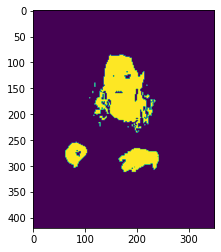

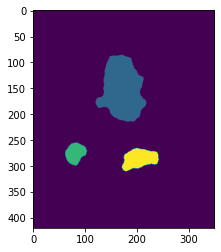

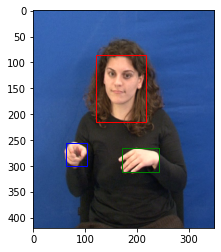

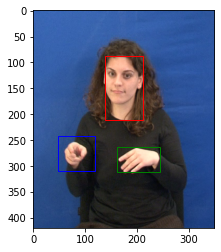

In [ ]:
mat = io.loadmat("./Part1/skinSamplesRGB.mat")
image = cv2.cvtColor(mat['skinSamplesRGB'], cv2.COLOR_RGB2YCrCb)
image = image.astype(np.float64)/255

flattened_img = np.concatenate(image[:, :, 1:], axis = 0)

mcr = np.mean(flattened_img[:, 0])
mcb = np.mean(flattened_img[:, 1])
mu = [mcr, mcb]
cov = np.cov(flattened_img.T)

first_frame = cv2.imread("./Part1/1.png")
first_frame_RGB = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2YCrCb)
first_frame = first_frame.astype(np.float64)/255

boundingboxes = fd(first_frame, mu, cov)

fig, ax = plt.subplots()
ax.imshow(first_frame_RGB)

head = plt.Rectangle((boundingboxes[0][0], boundingboxes[0][1]), boundingboxes[0][2], boundingboxes[0][3], edgecolor='r', facecolor='none')
left = plt.Rectangle((boundingboxes[1][0], boundingboxes[1][1]), boundingboxes[1][2], boundingboxes[1][3], edgecolor='b', facecolor='none')
right = plt.Rectangle((boundingboxes[2][0], boundingboxes[2][1]), boundingboxes[2][2], boundingboxes[2][3], edgecolor='g', facecolor='none')

ax.add_patch(head)
ax.add_patch(left)
ax.add_patch(right)

print("Head bounding box:", boundingboxes[0])
print("Left hand bounding box:", boundingboxes[1])
print("Right hand bounding box:", boundingboxes[2])

optimalboundingboxes = [[138, 88, 73, 123],
                        [47, 243, 71, 66],
                        [162, 264, 83, 48]]

fig, ax = plt.subplots()
ax.imshow(first_frame_RGB)

head = plt.Rectangle((optimalboundingboxes[0][0], optimalboundingboxes[0][1]), optimalboundingboxes[0][2], optimalboundingboxes[0][3], edgecolor='r', facecolor='none')
left = plt.Rectangle((optimalboundingboxes[1][0], optimalboundingboxes[1][1]), optimalboundingboxes[1][2], optimalboundingboxes[1][3], edgecolor='b', facecolor='none')
right = plt.Rectangle((optimalboundingboxes[2][0], optimalboundingboxes[2][1]), optimalboundingboxes[2][2], optimalboundingboxes[2][3], edgecolor='g', facecolor='none')

ax.add_patch(head)
ax.add_patch(left)
ax.add_patch(right)

## Μέρος 1.2.1

In [ ]:
def lk(img1, img2, features, rho=1, epsilon=0.01, dx0=0, dy0=0):

    n = int(np.ceil(3*rho)*2 + 1)
    
    kernel = cv2.getGaussianKernel(n, rho)
    kernel = kernel @ kernel.T
    
    x0, y0 = np.meshgrid(np.arange(img1.shape[1]), np.arange(img1.shape[0]))
    ix, iy = np.gradient(img1)
    directions = []
    
    for corner in features:
        d = [dy0, dx0]
        x = int(corner[0])
        y = int(corner[1])
        
        for _ in range(100):
    
            shifted_img = ndi.map_coordinates(img1, [np.ravel(y0 + d[0]), np.ravel(x0 + d[1])], order=1).reshape(img1.shape)
            A1 = ndi.map_coordinates(ix, [np.ravel(y0 + d[0]), np.ravel(x0 + d[1])], order=1).reshape(ix.shape) 
            A2 = ndi.map_coordinates(iy, [np.ravel(y0 + d[0]), np.ravel(x0 + d[1])], order=1).reshape(iy.shape)  
            
            E = img2 - shifted_img
        
            a11 = cv2.filter2D(A1**2, -1, kernel) + epsilon
            a12 = cv2.filter2D(A1*A2, -1, kernel)
            a22 = cv2.filter2D(A2**2, -1, kernel) + epsilon
        
            a = np.linalg.inv([[a11[y][x], a12[y][x]],
                               [a12[y][x], a22[y][x]]])
            
            b1 = cv2.filter2D(A1*E, -1, kernel)
            b2 = cv2.filter2D(A2*E, -1, kernel)
            
            b = np.array([b1[y][x], b2[y][x]])
            
            u = a @ b

            if abs(u[0]) < 1e-3 and abs(u[1])< 1e-3:
                break
            else:
                d += u
            
        d = d[::-1]  
        directions.append(d)
    
    directions = np.array(directions)
    return directions.T[0], directions.T[1]

In [ ]:
def plot_quiver(img1, img2):
  img2 *= 255
  img2 = img2.astype(np.uint8)
  features = cv2.goodFeaturesToTrack(img2, 15, 0.01, 5).astype(np.uint8)
  features = np.resize(features, (features.shape[0], features.shape[2]))
  img2 = img2.astype(np.float64)
  img2 /= 255

  dx, dy = lk(img1, img2, features)

  plt.figure()
  plt.xlim([0, img1.shape[1]])
  plt.ylim([0, img1.shape[0]])
  plt.gca().invert_yaxis()
  plt.gca().set_aspect('equal') 
  plt.quiver(features.T[0], features.T[1], -dx, -dy, angles = 'xy', scale = 100)
  return dx, dy

(array([1.01129886, 0.94712639, 0.80250871, 0.72433792, 1.07224033,
        0.69829108, 0.904039  , 1.03337254, 0.42496843, 0.65667234,
        0.44096585, 1.0322029 , 0.79051975, 0.50719656, 1.02539846]),
 array([2.54137143, 2.61517448, 1.45342239, 2.36837554, 1.12542461,
        2.67641282, 2.60251064, 2.00879259, 1.00835032, 2.63432178,
        1.16036172, 2.01818539, 1.19904511, 1.12116694, 2.17365171]))

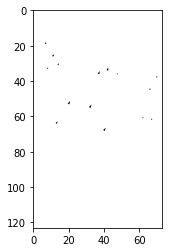

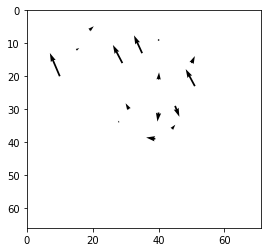

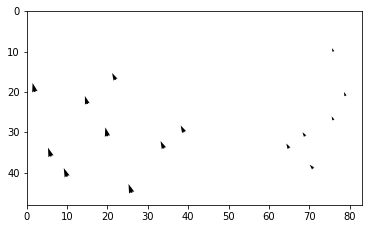

In [ ]:
first_frame = cv2.imread("./Part1/1.png")
first_frame_colored = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
first_frame = first_frame.astype(np.float64)/255

second_frame = cv2.imread("./Part1/2.png")
second_frame_colored = cv2.cvtColor(second_frame, cv2.COLOR_BGR2RGB)
second_frame = cv2.cvtColor(second_frame, cv2.COLOR_BGR2GRAY)
second_frame = second_frame.astype(np.float64)/255

img1_head = first_frame[88:88+123, 138:138+73]
img2_head = second_frame[88:88+123, 138:138+73]

img1_left = first_frame[243:243+66, 47:47+71]
img2_left = second_frame[243:243+66, 47:47+71]

img1_right = first_frame[264:264+48, 162:162+83]
img2_right = second_frame[264:264+48, 162:162+83]

plot_quiver(img1_head, img2_head)
plot_quiver(img1_left, img2_left)
plot_quiver(img1_right, img2_right)

[ 0.18419437 -2.         -2.         -2.         -1.99999994 -1.99999998
 -1.99965257 -1.99999717 -1.99999999 -1.99999931 -1.99973147 -1.99999999
 -1.99991643 -2.00000322 -1.9999648 ] [ 0.31776547 -1.         -1.         -1.         -0.9999999  -0.99999995
 -0.99978719 -1.00000259 -0.99999993 -1.00000132 -1.00010187 -0.99999999
 -0.9998826  -1.00000006 -1.00002727]


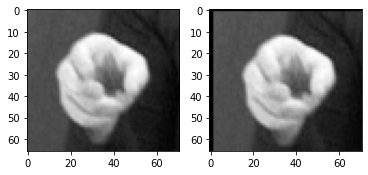

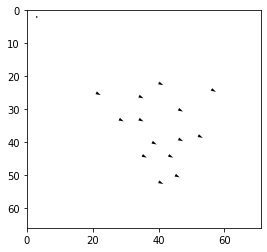

In [ ]:
x0, y0 = np.meshgrid(np.arange(img1_left.shape[1]), np.arange(img1_left.shape[0]))
img2_left = ndi.map_coordinates(img1_left, [np.ravel(y0-1), np.ravel(x0-2)], order=1).reshape(img1_left.shape)

f, ax = plt.subplots(1,2)
ax[0].imshow(img1_left, 'gray')
ax[1].imshow(img2_left, 'gray')

dx, dy = plot_quiver(img1_left, img2_left)
print(dx, dy)

## Μέρος 1.2.2

In [ ]:
def displ(dx, dy):
    threshold = 1
    energy = dx**2 + dy**2
    energy = energy > threshold
    if energy.sum() == 0:
      return 0.0, 0.0
    else:
      dx *= energy
      dy *= energy
      return dx.sum()/energy.sum(), dy.sum()/energy.sum()

## Μέρος 1.2.3

In [ ]:
def multiscale_lk(img1, img2, rho=1, epsilon=0.01, dx0=0, dy0=0, num_of_scales=3):
    n = int(np.ceil(3*3)*2 + 1)
    kernel = cv2.getGaussianKernel(n, 3)
    kernel = kernel @ kernel.T
    
    scales = [[img1, img2]]
    for i in range(num_of_scales):
        img1 = cv2.filter2D(img1, -1, kernel)
        img1 = cv2.resize(img1, (img1.shape[1]//2, img1.shape[0]//2))
        img2 = cv2.filter2D(img2, -1, kernel)
        img2 = cv2.resize(img2, (img2.shape[1]//2, img2.shape[0]//2))
        scales.append([img1, img2])

    scales = scales[::-1]
    
    for i, [img1, img2] in enumerate(scales):
        img2 *= 255
        img2 = img2.astype(np.uint8)
        features = cv2.goodFeaturesToTrack(img2, 15, 0.01, 5).astype(np.uint8)
        features = np.resize(features, (features.shape[0], features.shape[2]))
        img2 = img2.astype(np.float64)
        img2 /= 255

        dx, dy = lk(img1, img2, features, rho, epsilon, dx0, dy0)
        dx0, dy0 = displ(2*dx, 2*dy)
           
    return dx, dy, features

In [ ]:
def plot_quiver_multiscale(img1, img2):
  dx, dy, features = multiscale_lk(img1, img2)

  plt.figure()
  plt.xlim([0, img1.shape[1]])
  plt.ylim([0, img1.shape[0]])
  plt.gca().invert_yaxis()
  plt.gca().set_aspect('equal') 
  plt.quiver(features.T[0], features.T[1], -dx, -dy, angles = 'xy', scale = 100)

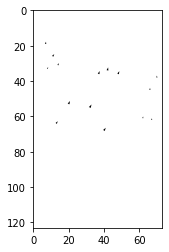

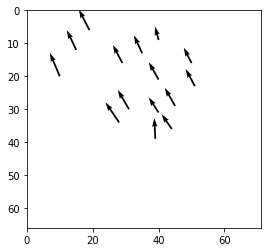

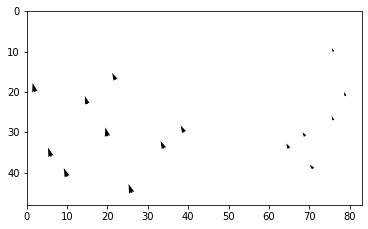

In [ ]:
first_frame = cv2.imread("./Part1/1.png")
first_frame_colored = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
first_frame = first_frame.astype(np.float64)/255

second_frame = cv2.imread("./Part1/2.png")
second_frame_colored = cv2.cvtColor(second_frame, cv2.COLOR_BGR2RGB)
second_frame = cv2.cvtColor(second_frame, cv2.COLOR_BGR2GRAY)
second_frame = second_frame.astype(np.float64)/255

img1_head = first_frame[88:88+123, 138:138+73]
img2_head = second_frame[88:88+123, 138:138+73]

img1_left = first_frame[243:243+66, 47:47+71]
img2_left = second_frame[243:243+66, 47:47+71]

img1_right = first_frame[264:264+48, 162:162+83]
img2_right = second_frame[264:264+48, 162:162+83]

plot_quiver_multiscale(img1_head, img2_head)
plot_quiver_multiscale(img1_left, img2_left)
plot_quiver_multiscale(img1_right, img2_right)

## Test:

In [ ]:
def lk_for_one_part(img1, img2, boundingboxes, multiscale):
  [x, y, w, h] = boundingboxes
  img1 = img1[y:y+h, x:x+w]
  img2 = img2[y:y+h, x:x+w]

  if multiscale:
    dx, dy, _ = multiscale_lk(img1, img2)
  else:
    img2*= 255
    img2 = img2.astype(np.uint8)
    features = cv2.goodFeaturesToTrack(img2, 15, 0.01, 5).astype(np.uint8)
    features = np.resize(features, (features.shape[0], features.shape[2]))
    img2 = img2.astype(np.float64)
    img2 /= 255

    dx, dy = lk(img1, img2, features)

  dx, dy = np.round(displ(dx, dy))
  return dx, dy


In [ ]:
def Visualization(img1, img2, boundingboxes, multiscale):
  img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
  img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

  img1_gray = img1_gray.astype(np.float32)/255
  img2_gray = img2_gray.astype(np.float32)/255

  dx_head, dy_head = lk_for_one_part(img1_gray, img2_gray, boundingboxes[0], multiscale)
  dx_left, dy_left = lk_for_one_part(img1_gray, img2_gray, boundingboxes[1], multiscale)
  dx_right, dy_right = lk_for_one_part(img1_gray, img2_gray, boundingboxes[2], multiscale)

  new_boundingboxes = [[int(boundingboxes[0][0] - dx_head), int(boundingboxes[0][1] - dy_head), boundingboxes[0][2], boundingboxes[0][3]],
                       [int(boundingboxes[1][0] - dx_left), int(boundingboxes[1][1] - dy_left), boundingboxes[1][2], boundingboxes[1][3]],
                       [int(boundingboxes[2][0] - dx_right), int(boundingboxes[2][1] - dy_right), boundingboxes[2][2], boundingboxes[2][3]]]

  fig, ax = plt.subplots()
  ax.imshow(img2)

  head = plt.Rectangle((new_boundingboxes[0][0], new_boundingboxes[0][1]), new_boundingboxes[0][2], new_boundingboxes[0][3], edgecolor='r', facecolor='none')
  left = plt.Rectangle((new_boundingboxes[1][0], new_boundingboxes[1][1]), new_boundingboxes[1][2], new_boundingboxes[1][3], edgecolor='b', facecolor='none')
  right = plt.Rectangle((new_boundingboxes[2][0], new_boundingboxes[2][1]), new_boundingboxes[2][2], new_boundingboxes[2][3], edgecolor='g', facecolor='none')

  ax.add_patch(head)
  ax.add_patch(left)
  ax.add_patch(right)
  return new_boundingboxes

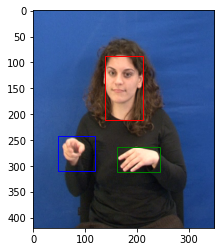

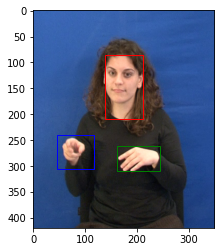

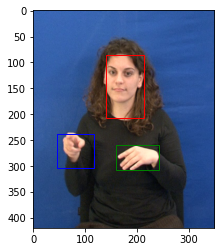

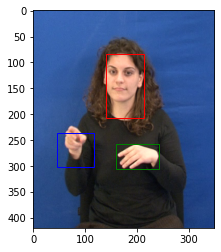

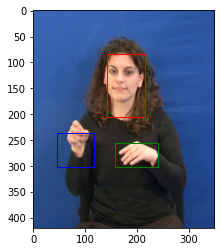

In [ ]:
for i in range(1, 5):
  img1 = cv2.imread("./Part1/{}.png".format(i))
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  img2 = cv2.imread("./Part1/{}.png".format(i+1))
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
  if i == 1:
    boundingboxes = [[138, 88, 73, 123],
                     [47, 243, 71, 66],
                     [162, 264, 83, 48]]
    fig, ax = plt.subplots()
    ax.imshow(img2)

    head = plt.Rectangle((boundingboxes[0][0], boundingboxes[0][1]), boundingboxes[0][2], boundingboxes[0][3], edgecolor='r', facecolor='none')
    left = plt.Rectangle((boundingboxes[1][0], boundingboxes[1][1]), boundingboxes[1][2], boundingboxes[1][3], edgecolor='b', facecolor='none')
    right = plt.Rectangle((boundingboxes[2][0], boundingboxes[2][1]), boundingboxes[2][2], boundingboxes[2][3], edgecolor='g', facecolor='none')

    ax.add_patch(head)
    ax.add_patch(left)
    ax.add_patch(right)

  boundingboxes = Visualization(img1, img2, boundingboxes, multiscale = False)


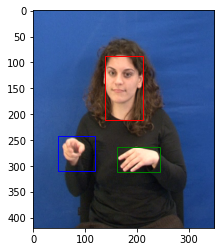

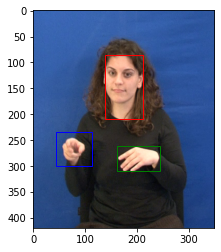

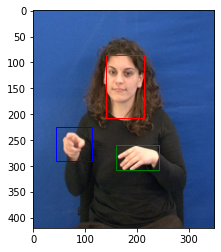

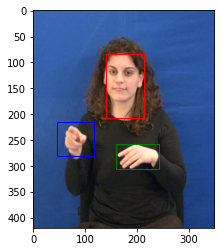

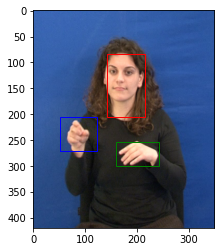

In [ ]:
for i in range(1, 5):
  img1 = cv2.imread("./Part1/{}.png".format(i))
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  img2 = cv2.imread("./Part1/{}.png".format(i+1))
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
  if i == 1:
    boundingboxes = [[138, 88, 73, 123],
                     [47, 243, 71, 66],
                     [162, 264, 83, 48]]
    fig, ax = plt.subplots()
    ax.imshow(img2)

    head = plt.Rectangle((boundingboxes[0][0], boundingboxes[0][1]), boundingboxes[0][2], boundingboxes[0][3], edgecolor='r', facecolor='none')
    left = plt.Rectangle((boundingboxes[1][0], boundingboxes[1][1]), boundingboxes[1][2], boundingboxes[1][3], edgecolor='b', facecolor='none')
    right = plt.Rectangle((boundingboxes[2][0], boundingboxes[2][1]), boundingboxes[2][2], boundingboxes[2][3], edgecolor='g', facecolor='none')

    ax.add_patch(head)
    ax.add_patch(left)
    ax.add_patch(right)

  boundingboxes = Visualization(img1, img2, boundingboxes, True)

# Μέρος 2:

## Μέρος 2.1:

In [126]:
def harrisDetector3D(video, s=1, sigma=4, t=1.5, k=0.005):
    kernel = np.array([-1, 0, 1]).astype(np.float32)
    
    lx = ndi.convolve1d(video, kernel, axis = 0)
    ly = ndi.convolve1d(video, kernel, axis = 1)
    lt = ndi.convolve1d(video, kernel, axis = 2)
    
    nxy = int(np.ceil(3*s*sigma)*2 + 1)
    g =  cv2.getGaussianKernel(nxy, s*sigma).reshape(nxy)
    nt = int(np.ceil(3*s*t)*2 + 1)
    gt = cv2.getGaussianKernel(nt, s*t).reshape(nt)


    m11 = ndi.convolve1d(ndi.convolve1d(ndi.convolve1d(lx**2, gt, axis = 2), g, axis = 1), g, axis = 0)
    m12 = ndi.convolve1d(ndi.convolve1d(ndi.convolve1d(lx*ly, gt, axis = 2), g, axis = 1), g, axis = 0)
    m13 = ndi.convolve1d(ndi.convolve1d(ndi.convolve1d(lx*lt, gt, axis = 2), g, axis = 1), g, axis = 0)
    m22 = ndi.convolve1d(ndi.convolve1d(ndi.convolve1d(ly**2, gt, axis = 2), g, axis = 1), g, axis = 0)
    m23 = ndi.convolve1d(ndi.convolve1d(ndi.convolve1d(ly*lt, gt, axis = 2), g, axis = 1), g, axis = 0)
    m33 = ndi.convolve1d(ndi.convolve1d(ndi.convolve1d(lt**2, gt, axis = 2), g, axis = 1), g, axis = 0)
    
    det = m11*(m22*m33 - m23**2) - m12*(m12*m33 - m13*m23) + m13*(m12*m23 - m22*m13) 
    trace = m11 + m22 + m33
    H = det - k*trace**3 

    B_sq = disk_strel(3)
    cond1 = (H == cv2.dilate(H ,B_sq))
    cond2 = (H > 0.001*H.max())
    
    H *= cond1*cond2

    corners = np.dstack(np.unravel_index(np.argsort(np.ravel(H)), H.shape))[0].T
    scales = np.zeros(120*160*200) + s*sigma
    corners = np.array([corners[1], corners[0], corners[2], scales]).T
    if corners.shape[0] > 500:
      corners = corners[-500:, :]
    return corners

In [127]:
def gaborDetector(video, sigma=4, t=1.5):
  x = np.linspace(-2*t, 2*t, int(4*t+1))
  w = 4/t

  hev = np.cos(2*np.pi*x*w)*np.exp(-x**2/(2*t**2))
  hev /= np.linalg.norm(hev, 1)
  hod = np.sin(2*np.pi*x*w)*np.exp(-x**2/(2*t**2))
  hod /= np.linalg.norm(hod, 1)

  n = int(np.ceil(3*sigma)*2 + 1)
  g = cv2.getGaussianKernel(n, sigma)
  g2d = g @ g.T
  for i in range(video.shape[2]):
    video[:, :, i] = cv2.filter2D(video[:, :, i], -1, g2d)

  h1 = ndi.convolve1d(video, hev, axis=2)
  h2 = ndi.convolve1d(video, hod, axis=2)
  H = h1**2 + h2**2

  B_sq = disk_strel(3)
  cond1 = (H == cv2.dilate(H ,B_sq))
  cond2 = (H > 0.001*H.max())
    
  H *= cond1*cond2

  corners = np.dstack(np.unravel_index(np.argsort(np.ravel(H)), H.shape))[0].T
  scales = np.zeros(120*160*200) + sigma
  corners = np.array([corners[1], corners[0], corners[2], scales]).T
  if corners.shape[0] > 500:
    corners = corners[-500:, :]
  return corners

In [ ]:
with open('./traininng_videos.txt') as f:
    videos = f.readlines()

In [130]:
video_path1 = './running_videos/' + videos[0][:-1]

video = p2.read_video(video_path1, 200, 0)
harris_corners = harrisDetector3D(video.astype(np.float32)/255)
p2.show_detection(video, harris_corners, save_path = './running_videos')
!ffmpeg -i ./running_videos/frame%d.png -c:v libx264 -vf fps=25 ./harris_running.mp4

gabor_corners = gaborDetector(video.astype(np.float32)/255)
p2.show_detection(video, harris_corners, save_path = './running_videos')
!ffmpeg -i ./running_videos/frame%d.png -c:v libx264 -vf fps=25 ./gabor_running.mp4

In [ ]:
video_path2 = './boxing_videos/' + videos[12][:-1]

video = p2.read_video(video_path2, 200, 0)
harris_corners = harrisDetector3D(video.astype(np.float32)/255)
p2.show_detection(video, harris_corners, save_path = './boxing_videos')
!ffmpeg -i ./boxing_videos/frame%d.png -c:v libx264 -vf fps=25 ./harris_boxing.mp4

gabor_corners = gaborDetector(video.astype(np.float32)/255)
p2.show_detection(video, harris_corners, save_path = './boxing_videos')
!ffmpeg -i ./boxing_videos/frame%d.png -c:v libx264 -vf fps=25 ./gabor_boxing.mp4

In [ ]:
video_path3 = './walking_videos/' + videos[24][:-1]

video = p2.read_video(video_path3, 200, 0)
harris_corners = harrisDetector3D(video.astype(np.float32)/255)
p2.show_detection(video, harris_corners, save_path = './walking_videos')
!ffmpeg -i ./walking_videos/frame%d.png -c:v libx264 -vf fps=25 ./harris_walking.mp4

gabor_corners = gaborDetector(video.astype(np.float32)/255)
p2.show_detection(video, harris_corners, save_path = './walking_videos')
!ffmpeg -i ./walking_videos/frame%d.png -c:v libx264 -vf fps=25 ./gabor_walking.mp4


## Μέρος 2.2:

In [124]:
def localDescriptors(video, descriptor, corners, nbins, grid_size):

  grad_x, grad_y, _ = np.gradient(video)
  flow_x = video.copy().astype(np.float32)
  flow_y = video.copy().astype(np.float32)

  for i in range(video.shape[2]-1):
    oflow = cv2.optflow.DualTVL1OpticalFlow_create(nscales=1)
    flow = oflow.calc(video[:, :, 0], video[:, :, 1], None)
    flow_x[:, :, i] = flow[:, :, 0]
    flow_y[:, :, i] = flow[:, :, 1]

  HOG = []
  HOF = []

  if descriptor == 'HOG':
    HOG = []
    for corner in corners:
      t = corner[2]
      s = corner[3]
      max_x = min(corner[0] + 4*s, 160)
      min_x = max(corner[0] - 4*s, 0)
      max_y = min(corner[1] + 4*s, 120)
      min_y = max(corner[1] - 4*s, 0)
    
      grad_gx = grad_x[min_y:max_y, min_x:max_x, t]
      grad_gy = grad_y[min_y:max_y, min_x:max_x, t]

      HOG.append(p2.orientation_histogram(grad_gy, grad_gx, nbins, grid_size))

    HOG = np.array(HOG)
    return HOG
    
  elif descriptor == 'HOF':
    HOF = []
    for corner in corners:
      t = corner[2]
      s = corner[3]
      max_x = min(corner[0] + 4*s, 160)
      min_x = max(corner[0] - 4*s, 0)
      max_y = min(corner[1] + 4*s, 120)
      min_y = max(corner[1] - 4*s, 0)
      flow_gx = flow_x[min_y:max_y, min_x:max_x, t]
      flow_gy = flow_y[min_y:max_y, min_x:max_x, t]

      HOF.append(p2.orientation_histogram(flow_gy, flow_gx, nbins, grid_size))

    HOF = np.array(HOF)
    return HOF
    
  elif descriptor == 'HOGHOF':
    HOG = []
    HOF = []
    for corner in corners:
      t = corner[2]
      s = corner[3]
      max_x = min(corner[0] + 4*s, 160)
      min_x = max(corner[0] - 4*s, 0)
      max_y = min(corner[1] + 4*s, 120)
      min_y = max(corner[1] - 4*s, 0)
      grad_gx = grad_x[min_y:max_y, min_x:max_x, t]
      grad_gy = grad_y[min_y:max_y, min_x:max_x, t]

      HOG.append(p2.orientation_histogram(grad_gy, grad_gx, nbins, grid_size))

      flow_gx = flow_x[min_y:max_y, min_x:max_x, t]
      flow_gy = flow_y[min_y:max_y, min_x:max_x, t]

      HOF.append(p2.orientation_histogram(flow_gy, flow_gx, nbins, grid_size))

    HOG = np.array(HOG)
    HOF = np.array(HOF)
    HOGHOF = np.concatenate((HOG, HOF), axis=1)
    return HOGHOF

## Μέρος 2.3

In [133]:
def splitDataset(detector, descriptor, nbins, grid_size):
  all_videos = os.listdir('./all_videos')
  with open('./traininng_videos.txt') as f:
    training_videos = f.readlines()
  
  for i in range(len(training_videos)):
    training_videos[i] = training_videos[i][:-1]

  train_desc = []
  train_labels = []
  test_desc = []
  test_labels = []
  for i, video_name in enumerate(all_videos):
    video = p2.read_video('./all_videos/' + video_name, 200, 0).astype(np.uint8)
    corners = detector(video.astype(np.float32)/255).astype(np.uint8)
    ldesc = localDescriptors(video, descriptor, corners, nbins, grid_size)
    
    if video_name in training_videos:
      train_desc.append(ldesc)
      if 'running' in video_name:
        train_labels.append('running')
      elif 'boxing' in video_name:
        train_labels.append('boxing')
      elif 'walking' in video_name:
        train_labels.append('walking')

    else:
      test_desc.append(ldesc)
      if 'running' in video_name:
        test_labels.append('running')
      elif 'boxing' in video_name:
        test_labels.append('boxing')
      elif 'walking' in video_name:
        test_labels.append('walking')
  
  return np.array(train_desc), np.array(train_labels), np.array(test_desc), np.array(test_labels)

In [134]:
def classifyVideos(detector, descriptor, nbins=9, grid_size=np.array([3, 3]), D=500):
  train_desc, train_labels, test_desc, test_labels = splitDataset(detector, descriptor, nbins, grid_size)
  bow_train, bow_test = p2.bag_of_words(train_desc, test_desc, num_centers = D)
  accuracy, pred = p2.svm_train_test(bow_train, train_labels, bow_test, test_labels)
  return accuracy, pred, test_labels

In [137]:
acc, pred, true = classifyVideos(harrisDetector3D, 'HOG')
print("Classification with Harris Detector and HOG features:")
print("Accuracy:", acc)
print("Predictions:", pred)
print("True labels:", true)
print()

Classification with Harris Detector and HOG features:
Accuracy: 0.9166666666666666
Predictions: ['running' 'boxing' 'boxing' 'running' 'walking' 'walking' 'running'
 'running' 'walking' 'running' 'walking' 'boxing']
True labels: ['running' 'boxing' 'boxing' 'running' 'walking' 'walking' 'running'
 'running' 'walking' 'boxing' 'walking' 'boxing']



In [138]:
acc, pred, true = classifyVideos(harrisDetector3D, 'HOF')
print("Classification with Harris Detector and HOF features:")
print("Accuracy:", acc)
print("Predictions:", pred)
print("True labels:", true)
print()

Classification with Harris Detector and HOF features:
Accuracy: 0.5833333333333334
Predictions: ['running' 'boxing' 'boxing' 'walking' 'boxing' 'running' 'running'
 'running' 'running' 'boxing' 'running' 'boxing']
True labels: ['running' 'boxing' 'boxing' 'running' 'walking' 'walking' 'running'
 'running' 'walking' 'boxing' 'walking' 'boxing']



In [139]:
acc, pred, true = classifyVideos(harrisDetector3D, 'HOGHOF')
print("Classification with Harris Detector and HOGHOF features:")
print("Accuracy:", acc)
print("Predictions:", pred)
print("True labels:", true)
print()

Classification with Harris Detector and HOGHOF features:
Accuracy: 0.6666666666666666
Predictions: ['running' 'boxing' 'boxing' 'boxing' 'walking' 'running' 'running'
 'running' 'running' 'boxing' 'running' 'boxing']
True labels: ['running' 'boxing' 'boxing' 'running' 'walking' 'walking' 'running'
 'running' 'walking' 'boxing' 'walking' 'boxing']



In [140]:
acc, pred, true = classifyVideos(gaborDetector, 'HOG')
print("Classification with Gabor Detector and HOG features:")
print("Accuracy:", acc)
print("Predictions:", pred)
print("True labels:", true)
print()

Classification with Gabor Detector and HOG features:
Accuracy: 0.6666666666666666
Predictions: ['walking' 'walking' 'boxing' 'walking' 'boxing' 'walking' 'running'
 'running' 'walking' 'boxing' 'walking' 'boxing']
True labels: ['running' 'boxing' 'boxing' 'running' 'walking' 'walking' 'running'
 'running' 'walking' 'boxing' 'walking' 'boxing']



In [141]:
acc, pred, true = classifyVideos(gaborDetector, 'HOF')
print("Classification with Gabor Detector and HOF features:")
print("Accuracy:", acc)
print("Predictions:", pred)
print("True labels:", true)
print()

Classification with Gabor Detector and HOF features:
Accuracy: 0.5
Predictions: ['running' 'boxing' 'boxing' 'walking' 'boxing' 'running' 'running'
 'running' 'running' 'boxing' 'running' 'walking']
True labels: ['running' 'boxing' 'boxing' 'running' 'walking' 'walking' 'running'
 'running' 'walking' 'boxing' 'walking' 'boxing']



In [142]:
acc, pred, true = classifyVideos(gaborDetector, 'HOGHOF')
print("Classification with Gabor Detector and HOGHOF features:")
print("Accuracy:", acc)
print("Predictions:", pred)
print("True labels:", true)
print()

Classification with Gabor Detector and HOGHOF features:
Accuracy: 0.5
Predictions: ['walking' 'boxing' 'boxing' 'boxing' 'boxing' 'running' 'running'
 'running' 'running' 'boxing' 'running' 'boxing']
True labels: ['running' 'boxing' 'boxing' 'running' 'walking' 'walking' 'running'
 'running' 'walking' 'boxing' 'walking' 'boxing']

